# Data Augmentation Exercise
---
## 데이터가 더 부족한 세상으로!

[여기 참고](https://www.cs.toronto.edu/~kriz/cifar.html)

## Data Loading

In [36]:
from tensorflow.keras.datasets.cifar100 import load_data

In [37]:
(x_train, y_train), (x_test, y_test) = load_data()

In [38]:
import random
import matplotlib.pyplot as plt

이미지 인덱스 : [88]


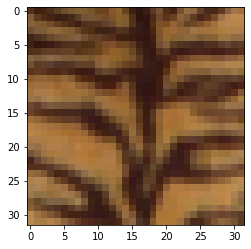

In [39]:
### 반복실행
idx = random.randint(0,49999)
print(f"이미지 인덱스 : {y_train[idx]}")
plt.imshow(x_train[idx])
plt.show()

In [40]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [41]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import sklearn

## Validation set 생성

In [42]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2023)

In [43]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((40000, 32, 32, 3), (40000, 1), (10000, 32, 32, 3), (10000, 1))

## X : Min-Max Scaling

In [44]:
max_x, min_x = x_train.max(), x_train.min()

max_x, min_x

(255, 0)

In [45]:
x_train = (x_train - min_x) / (max_x - min_x)
x_val = (x_val - min_x) / (max_x - min_x)
x_test = (x_test - min_x) / (max_x - min_x)

In [46]:
x_train.max(), x_train.min()

(1.0, 0.0)

## Y : One-Hot Encoding

In [47]:
y_train.shape

(40000, 1)

In [48]:
from keras.utils import to_categorical

class_n = len(np.unique(y_train))

y_train = to_categorical(y_train, class_n)
y_val = to_categorical(y_val, class_n)
y_test = to_categorical(y_test, class_n)

In [49]:
x_train.shape, y_train.shape

((40000, 32, 32, 3), (40000, 100))

## **Data Augmentation**

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [51]:
datagen = ImageDataGenerator(rotation_range=25,
                             width_shift_range=0.05,
                             height_shift_range=0.05, 
                             zoom_range=0.15, 
                             shear_range=0.15, 
                             horizontal_flip=True, 
                             vertical_flip=True)

In [52]:
datagen.fit(x_train)

In [53]:
!mkdir /content/temp/

In [55]:
train_gen = datagen.flow(x_train, y_train, 
                         save_to_dir='/content/temp/',
                         save_prefix = 'temp',
                         save_format='jpg')

## Keras로 자유롭게 CNN 모델링

1. [이 구조를 미니 버전으로 활용해봐도 좋다](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
2. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.

In [58]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

# 1. 세션 클리어
keras.backend.clear_session()
# 2. 모델 사슬 엮기
il = Input(shape = (32,32,3))

hl = Conv2D(filters = 32,
            kernel_size = (3, 3),
            strides = (1, 1),
            padding = 'same',
            activation = 'relu')(il)
hl = Conv2D(filters = 32,
            kernel_size = (3, 3),
            strides = (1, 1),
            padding = 'same',
            activation = 'relu')(hl)
hl = MaxPool2D(pool_size = (2, 2))(hl)            
hl = BatchNormalization()(hl)

hl = Conv2D(filters = 64,
            kernel_size = (3, 3),
            strides = (1, 1),
            padding = 'same',
            activation = 'relu')(hl)
hl = Conv2D(filters = 64,
            kernel_size = (3, 3),
            strides = (1, 1),
            padding = 'same',
            activation = 'relu')(hl)
hl = MaxPool2D(pool_size = (2, 2))(hl)        
hl = BatchNormalization()(hl)


hl = Conv2D(filters = 128,
            kernel_size = (3, 3),
            strides = (1, 1),
            padding = 'same',
            activation = 'relu')(hl)
hl = Conv2D(filters = 128,
            kernel_size = (3, 3),
            strides = (1, 1),
            padding = 'same',
            activation = 'relu')(hl)
hl = MaxPool2D(pool_size = (2, 2))(hl)            
hl = BatchNormalization()(hl)


hl = Flatten()(hl)
hl = Dropout(0.25)(hl)
ol = Dense(100, activation = 'softmax')(hl)

model = keras.models.Model(il, ol)
# 3. 모델 컴파일
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'],
              optimizer = 'adam')
# 4. 모델요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496 

## Early Stopping을 이용한 학습

- 8 epoch 연속으로 val_loss가 개선되지 않았으면 멈추는 얼리스토핑 모델을 만드시오.

In [56]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 8,
                   verbose = 1,
                   restore_best_weights = True)

In [59]:
hist = model.fit(train_gen, epochs=10000, validation_data=(x_val, y_val), verbose = 1, callbacks=[es])

Epoch 1/10000
1250/1250 [==============================] - 60s 46ms/step - loss: 4.2084 - accuracy: 0.1009 - val_loss: 3.4411 - val_accuracy: 0.1836
Epoch 2/10000
1250/1250 [==============================] - 46s 37ms/step - loss: 3.3437 - accuracy: 0.1981 - val_loss: 3.2934 - val_accuracy: 0.2263
Epoch 3/10000
1250/1250 [==============================] - 46s 37ms/step - loss: 3.0078 - accuracy: 0.2555 - val_loss: 3.1565 - val_accuracy: 0.2512
Epoch 4/10000
1250/1250 [==============================] - 46s 37ms/step - loss: 2.8111 - accuracy: 0.2925 - val_loss: 2.6998 - val_accuracy: 0.3222
Epoch 5/10000
1250/1250 [==============================] - 47s 38ms/step - loss: 2.6467 - accuracy: 0.3258 - val_loss: 2.5604 - val_accuracy: 0.3494
Epoch 6/10000
1250/1250 [==============================] - 48s 38ms/step - loss: 2.5222 - accuracy: 0.3530 - val_loss: 2.4452 - val_accuracy: 0.3724
Epoch 7/10000
1250/1250 [==============================] - 47s 37ms/step - loss: 2.4309 - accuracy: 0.3728

* 예측값 생성 및 구조 변경

In [ ]:
y_pred = 

In [ ]:
single_y_pred = y_pred.argmax(axis=1)
single_y_test = y_test.argmax(axis=1)

* 성능 평가

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
test_acc = accuracy_score(single_y_test, single_y_pred)

In [ ]:
print(f'테스트셋 정확도 : {test_acc*100}%')

## 이미지 시각화

In [ ]:
import random as rd

In [ ]:
np.floor(y_pred[rand_n]*100)

* 반복 실행하여 확인해봅시다.

In [ ]:
rand_n = rd.randrange(0, single_y_test.shape[0])

print(f'id : {rand_n}')
print(f'실제 카테고리 인덱스 : {single_y_test[rand_n]}')
print(f'모델의 카테고리 인덱스 예측 : {single_y_pred[rand_n]}')

if single_y_test[rand_n] == single_y_pred[rand_n] :
    print('정답')
else :
    print('오답')

print('======================================')
print(f'모델의 카테고리별 확률 : \n{np.floor(y_pred[rand_n]*100)}%')
print('======================================')

plt.figure(figsize=(5,5))
plt.title(f'Category Index {single_y_test[rand_n]}')
plt.imshow(x_test[rand_n].reshape(32,32,3))
plt.show()

* 틀린 것만 확인해봅시다.

In [ ]:
y_tf = single_y_pred==single_y_test
false_idx = np.where(y_tf==False)[0]
false_len = len(false_idx)

idx = false_idx[rd.randrange(0, false_len)]

print(f'id : {idx}')
print(f'실제 카테고리 인덱스 : {single_y_test[idx]}')
print(f'모델의 카테고리 인덱스 예측 : {single_y_pred[idx]}')

if single_y_test[idx] == single_y_pred[idx] :
    print('정답')
else :
    print('오답')

print('======================================')
print(f'모델의 카테고리별 확률 : \n{np.floor(y_pred[rand_n]*100)}%')
print('======================================')

plt.figure(figsize=(5,5))
plt.title(f'Category Index {single_y_test[idx]}')
plt.imshow(x_test[idx].reshape(32,32,3))
plt.show()